In [8]:
!python --version

Python 3.8.13


# Extract Time Series Sentinel-2 data
## from Digital Earth Australia (DEA) via STAC

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import pystac_client
import odc.stac
# odc-stac library downloads DEA datasets stored in AWS
# when external to AWS (like outside DEA sandbox), AWS signed requests must be disabled
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

from datacube.utils.geometry import CRS, Geometry, BoundingBox
from datacube.model import GridSpec

# My helper class
from helperfunctions import begin_timer, end_timer, saveDataset, loadDataset
from dea_helperfunctions import DEA_HelperFunctions

from dea_tools.plotting import rgb, map_shapefile

### Constants

In [2]:
# configure helper functions
dea_fns = DEA_HelperFunctions()
basepath = "../datasets/Sentinel2withIndices_"
fileextn = ".pkl"

filespecifier = "DublinSA_2020to2022_Mar"

epsg3577 = 'EPSG:3577'            # EPSG:3577: GDA94 / Australian Albers projection


### Extract and plot Survey area tiles

<AxesSubplot:>

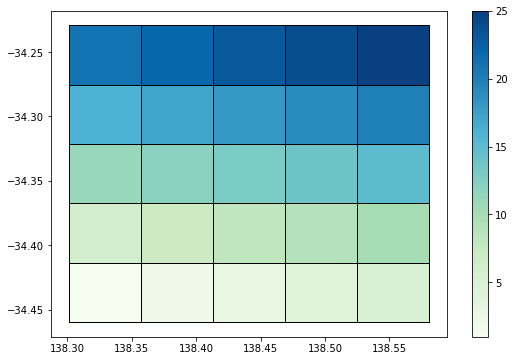

In [3]:
#Extract GeoDataFrame containing polygons
gdf_surveyarea = loadDataset(basepath + filespecifier + "_polygons" + fileextn)

# display Tile areas using GeoDataFrame
gdf_surveyarea.set_crs(epsg3577)
gdf_surveyarea.plot(column="tile", kind='geo', figsize=(9,6), cmap='GnBu', legend=True, edgecolor="black")

### Extract and display images from Survey area dataset

In [4]:
surveyarea_ds = [] # [timeband, tile number, polygon, dataset]
surveyarea_ds = loadDataset(basepath + filespecifier + fileextn)

In [5]:
surveyarea_filter = filter(lambda ds: (ds[1] == 2022)  # Year
                                    #& (ds[2] == 3),  # Month
                                    & (ds[4] == 13), # Tile
                                  surveyarea_ds)

surveyarea_tiles = list(surveyarea_filter)
surveyarea_tiles[0]

[['2022-03-01', '2022-03-05'],
 2022,
 3,
 4,
 13,
 <xarray.Dataset>
 Dimensions:      (time: 2, y: 539, x: 538)
 Coordinates:
   * time         (time) datetime64[ns] 2022-03-02T00:46:37.906772 2022-03-05T...
   * y            (y) float64 -3.761e+06 -3.761e+06 ... -3.767e+06 -3.767e+06
   * x            (x) float64 5.871e+05 5.871e+05 ... 5.925e+05 5.925e+05
     spatial_ref  int32 3577
 Data variables:
     nbart_blue   (time, y, x) uint16 dask.array<chunksize=(1, 539, 538), meta=np.ndarray>
     nbart_green  (time, y, x) uint16 dask.array<chunksize=(1, 539, 538), meta=np.ndarray>
     nbart_red    (time, y, x) uint16 dask.array<chunksize=(1, 539, 538), meta=np.ndarray>
     nbart_nir_1  (time, y, x) uint16 dask.array<chunksize=(1, 539, 538), meta=np.ndarray>
     NDVI         (time, y, x) float64 dask.array<chunksize=(1, 539, 538), meta=np.ndarray>
     kNDVI        (time, y, x) float64 dask.array<chunksize=(1, 539, 538), meta=np.ndarray>
     NDWI         (time, y, x) float64 dask.a

### Plot NIR and Additional Band Indices

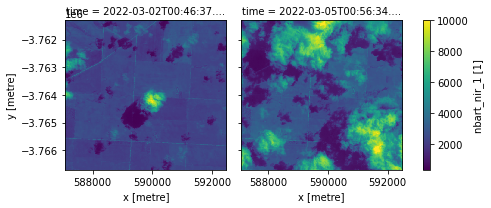

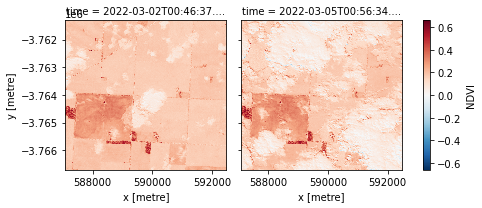

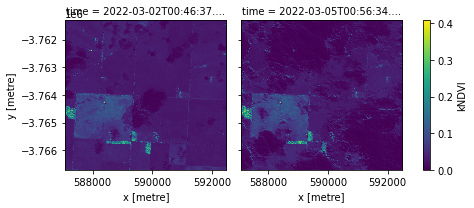

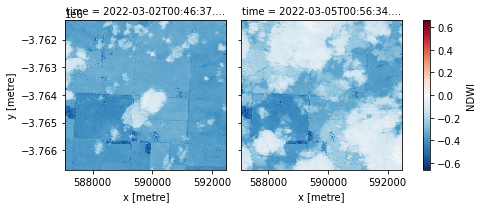

In [6]:
for surveyarea_tile in surveyarea_tiles:
    ds = surveyarea_tile[6] # extract xarray
    
    ds.nbart_nir_1.plot.imshow(col="time")
    ds.NDVI.plot.imshow(col="time")
    ds.kNDVI.plot.imshow(col="time")
    ds.NDWI.plot.imshow(col="time")

## Plot RGB

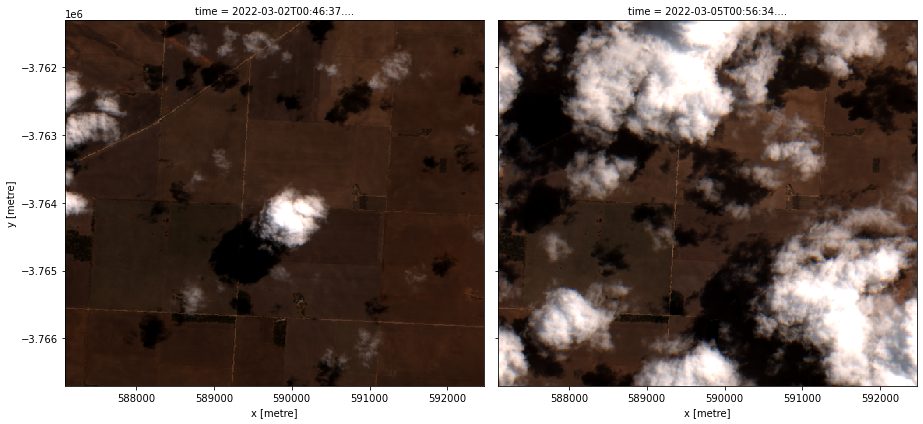

In [7]:
for surveyarea_tile in surveyarea_tiles:
    ds = surveyarea_tile[6] # extract xarray
    rgb(ds, bands=['nbart_red', 'nbart_green', 'nbart_blue'], col="time")